# Imports

In [2]:
# Std lib
from collections import namedtuple, Counter, defaultdict
from itertools import islice
import random
from glob import glob
from pprint import pprint as pp
from shutil import rmtree
import os

# Third party
import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
from pycl.pycl import *
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from scipy import stats

# Matplotlib and pandas setup
%matplotlib inline
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

# Prepare dataset

In [9]:
ref = "./extra_data/reference/Yeast_transcriptome.fa"
dry = False

for dir in ("extra_data/basecall/", "extra_data/alignment/", "extra_data/eventalign/") :
    rmtree (dir,ignore_errors=True)
    mkdir (dir)

for lab in ("WT", "KO"):
    jprint ("Process sample", lab, bold=True, size=120)
    
    jprint ("Create directories for sample", bold=True)
    mkdir (f"extra_data/basecall/{lab}")
    mkdir (f"extra_data/alignment/{lab}") 
    mkdir (f"./extra_data/eventalign/{lab}")
    
    jprint ("Basecalling", bold=True)
    cmd = f"read_fast5_basecaller.py --disable_filtering -r -t 4 -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i extra_data/raw/{lab} -s extra_data/basecall/{lab}"
    bash (virtualenv="Albacore_2.3.1", cmd=cmd, print_cmd=True, dry=dry)
        
    jprint ("Aligning", bold=True)
    fastq = glob (f"./extra_data/basecall/{lab}/workspace/*.fastq")[0]
    bam = f"extra_data/alignment/{lab}/reads.bam"
    cmd = f"minimap2 -ax map-ont -L -t 4 {ref} {fastq} | samtools view -bh -F 2328 -q 30 | samtools sort -o {bam}"
    bash (virtualenv="Minimap2_2.11", cmd=cmd, live="stderr", print_cmd=True, dry=dry)
    
    jprint ("Index BAM files", bold=True)
    cmd = f"samtools index {bam}"
    bash (cmd=cmd, print_cmd=True, dry=dry)
    
    jprint ("Index fast5 files", bold=True)
    fast5_dir = f"./extra_data/raw/{lab}"
    cmd = f"nanopolish index -d {fast5_dir} {fastq}"
    bash (virtualenv="Nanopolish_0.10.1", cmd=cmd, live="stderr", print_cmd=True, dry=dry)
    
    jprint ("Align events", bold=True)
    bam = f"./extra_data/alignment/{lab}/reads.bam"
    ref = "./extra_data/reference/Yeast_transcriptome.fa"
    event_align_outfn = f"./extra_data/eventalign/{lab}/eventalign.tsv"
    cmd = f"nanopolish eventalign -t 4 --reads {fastq} --bam {bam} --genome {ref} --samples > {event_align_outfn}"
    bash (virtualenv="Nanopolish_0.10.1", cmd=cmd, live="stderr", print_cmd=True, dry=dry)
    
    jprint ("Collapse events", bold=True)
    event_align_collapsed_outfn = f"./extra_data/eventalign/{lab}/eventalign_collapsed.tsv"
    cmd = f"NanopolishComp Eventalign_collapse -t 4 -i {event_align_outfn} -o {event_align_collapsed_outfn}"
    bash (virtualenv="Nanopolish_0.10.1", cmd=cmd, live="stderr", print_cmd=True, dry=dry)

Creating /home/aleg/Programming/nanocompore/tests/extra_data/basecall
Creating /home/aleg/Programming/nanocompore/tests/extra_data/alignment
Creating /home/aleg/Programming/nanocompore/tests/extra_data/eventalign


Creating /home/aleg/Programming/nanocompore/tests/extra_data/basecall/WT
Creating /home/aleg/Programming/nanocompore/tests/extra_data/alignment/WT
Creating /home/aleg/Programming/nanocompore/tests/extra_data/eventalign/WT


read_fast5_basecaller.py --disable_filtering -r -t 4 -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i extra_data/raw/WT -s extra_data/basecall/WT


minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq | samtools view -bh -F 2328 -q 30 | samtools sort -o extra_data/alignment/WT/reads.bam


[M::mm_idx_gen::0.295*1.00] collected minimizers
[M::mm_idx_gen::0.377*1.59] sorted minimizers
[M::main::0.378*1.59] loaded/built the index for 6713 target sequence(s)
[M::mm_mapopt_update::0.402*1.56] mid_occ = 38
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 6713
[M::mm_idx_stat::0.419*1.53] distinct minimizers: 1527846 (95.20% are singletons); average occurrences: 1.097; average spacing: 5.416
[M::worker_pipeline::0.548*1.59] mapped 399 sequences
[M::main] Version: 2.11-r797
[M::main] CMD: minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq
[M::main] Real time: 0.557 sec; CPU: 0.878 sec


samtools index extra_data/alignment/WT/reads.bam


nanopolish index -d ./extra_data/raw/WT ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq


[readdb] indexing ./extra_data/raw/WT
[readdb] num reads: 400, num reads with path to fast5: 400


nanopolish eventalign -t 4 --reads ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq --bam ./extra_data/alignment/WT/reads.bam --genome ./extra_data/reference/Yeast_transcriptome.fa --samples > ./extra_data/eventalign/WT/eventalign.tsv


[post-run summary] total reads: 328, unparseable: 0, qc fail: 5, could not calibrate: 0, no alignment: 0, bad fast5: 0


NanopolishComp Eventalign_collapse -t 4 -i ./extra_data/eventalign/WT/eventalign.tsv -o ./extra_data/eventalign/WT/eventalign_collapsed.tsv


[Eventalign_collapse] total reads: 323 [19.47 reads/s]


Creating /home/aleg/Programming/nanocompore/tests/extra_data/basecall/KO
Creating /home/aleg/Programming/nanocompore/tests/extra_data/alignment/KO
Creating /home/aleg/Programming/nanocompore/tests/extra_data/eventalign/KO


read_fast5_basecaller.py --disable_filtering -r -t 4 -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i extra_data/raw/KO -s extra_data/basecall/KO


minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq | samtools view -bh -F 2328 -q 30 | samtools sort -o extra_data/alignment/KO/reads.bam


[M::mm_idx_gen::0.284*1.00] collected minimizers
[M::mm_idx_gen::0.364*1.57] sorted minimizers
[M::main::0.365*1.57] loaded/built the index for 6713 target sequence(s)
[M::mm_mapopt_update::0.388*1.54] mid_occ = 38
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 6713
[M::mm_idx_stat::0.405*1.51] distinct minimizers: 1527846 (95.20% are singletons); average occurrences: 1.097; average spacing: 5.416
[M::worker_pipeline::0.496*1.57] mapped 396 sequences
[M::main] Version: 2.11-r797
[M::main] CMD: minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq
[M::main] Real time: 0.512 sec; CPU: 0.795 sec


samtools index extra_data/alignment/KO/reads.bam


nanopolish index -d ./extra_data/raw/KO ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq


[readdb] indexing ./extra_data/raw/KO
[readdb] num reads: 400, num reads with path to fast5: 400


nanopolish eventalign -t 4 --reads ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq --bam ./extra_data/alignment/KO/reads.bam --genome ./extra_data/reference/Yeast_transcriptome.fa --samples > ./extra_data/eventalign/KO/eventalign.tsv


[post-run summary] total reads: 296, unparseable: 0, qc fail: 1, could not calibrate: 2, no alignment: 0, bad fast5: 0


NanopolishComp Eventalign_collapse -t 4 -i ./extra_data/eventalign/KO/eventalign.tsv -o ./extra_data/eventalign/KO/eventalign_collapsed.tsv


[Eventalign_collapse] total reads: 294 [20.19 reads/s]


In [11]:
head ("extra_data/eventalign/KO/eventalign_collapsed.tsv", ignore_comment_line=True)

ref_pos ref_kmer n_events NNNNN_events mismatching_events mean       median  n_signals 
144     AGAGG    1        0            0                  124.20087  124.223 43        
145     GAGGT    2        0            0                  104.763405 104.707 36        
146     AGGTG    1        0            0                  114.68939  113.547 10        
147     GGTGC    2        0            0                  109.89428  109.195 28        
148     GTGCA    2        0            0                  88.36677   87.0261 56        
149     TGCAG    1        0            0                  107.35894  107.495 11        
150     GCAGC    2        0            0                  94.35902   93.6223 48        
151     CAGCT    2        0            0                  107.90285  110.351 15        
152     AGCTG    7        0            0                  117.151    117.287 135       



# Dev whitelist function

In [12]:
head ("/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx")
head ("/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv")

ref_id  ref_start ref_end read_id                              kmers NNNNN_kmers mismatching_kmers missing_kmers byte_offset byte_len 
YHR055C 0         171     6f885af6-5844-476e-9e51-133dc5617dfd 169   3           0                 2             0           8279     
YHR055C 1         182     2b01d98a-336e-40d9-b7c4-07895b9b10a2 175   6           0                 6             8280        8584     
YHR055C 0         155     4259fc88-b781-482a-bfa9-985dc424c733 154   5           0                 1             16865       7234     
YHR055C 0         170     d3bcaffe-3020-4a0b-a913-254a96e92efd 167   2           0                 3             24100       8211     
YHR055C 0         182     d978ef9e-b4b0-4998-ab41-6d9da2c50743 171   6           0                 11            32312       8386     
YHR055C 0         182     5baf52a9-27be-411b-9023-3d7681e60e90 177   5           0                 5             40699       8704     
YHR055C 1         172     0fd6188c-af31-43c0-bc69-3ced8

In [66]:
def whitelist (
    s1_fn,
    s2_fn,
    fasta_index_fn = None,
    min_cov = 10,
    max_NNNNN_kmers_freq = 0.2,
    max_mismatching_kmers_freq = 0.2,
    max_missing_kmers_freq = 0.2,
    verbose=True):

    # Read fasta index
    if verbose: print ("Read fasta index")
    ref_len_dict = _read_fasta_index (fn=fasta_index_fn)
    if verbose: print (f"\tTotal references: {len(ref_len_dict)}")

    # Create reference index for both files
    if verbose: print ("Read eventalign index files")
    ref_reads = _read_eventalign_index (s1_fn, s2_fn, max_NNNNN_kmers_freq, max_mismatching_kmers_freq, max_missing_kmers_freq)
    if verbose: print (f"\tTotal references found {len(ref_reads)}")
    
    # Intersect both samples
    if verbose: print ("Filter out references with low coverage")
    ref_reads = _select_ref (ref_reads=ref_reads, min_cov=min_cov)
    if verbose: print (f"\tTranscripts remaining after reference coverage filtering: {len(ref_reads)}")
    
    if verbose: print ("Compute coverage per reference and select intervals with high enough coverage")
    ref_interval_reads = OrderedDict ()
    for ref_id, sample_reads in ref_reads.items ():
        # Compute reference coverage
        cov_array = _compute_ref_cov (sample_reads=sample_reads, ref_len=ref_len_dict[ref_id])
        # Get coordinates of intervals with minimum coverage
        valid_interval_list = _get_valid_intervals (cov_array, min_cov)
        # Intesect reads with valid coverage for both samples
        ref_interval_reads [ref_id] = _intersect_reads_interval (valid_interval_list, sample_reads)
    
    return ref_interval_reads
        
def _read_fasta_index (fn):
    ref_len = OrderedDict ()
    with open (fn) as fp:
        for line in fp:
            ls = line.rstrip().split()
            ref_len[ls[0]] = int(ls[1])
    return ref_len

def _read_eventalign_index (s1_fn, s2_fn, max_NNNNN_kmers_freq, max_mismatching_kmers_freq, max_missing_kmers_freq):
    ref_reads = OrderedDict ()
    
    for lab, fn in ("S1", s1_fn), ("S2", s2_fn):
        with open (fn) as fp:
            # get field names from header
            header = fp.readline().rstrip().split()
            line_tuple = namedtuple("line_tuple", header)
            c = Counter ()
            for line in fp:
                ls = line.rstrip().split()
                lt = line_tuple (ls[0], int(ls[1]), int(ls[2]), ls[3], int(ls[4]), int(ls[5]) , int(ls[6]) , int(ls[7]) , int(ls[8]))
                # filter out reads with high number of problematic kmers
                if max_NNNNN_kmers_freq and lt.NNNNN_kmers/lt.kmers > max_NNNNN_kmers_freq:
                    c ["high NNNNN_kmers reads"] += 1
                elif max_mismatching_kmers_freq and lt.mismatching_kmers/lt.kmers > max_mismatching_kmers_freq:
                    c ["high mismatching_kmers reads"] += 1
                elif max_missing_kmers_freq and lt.missing_kmers/lt.kmers > max_missing_kmers_freq:
                    c ["high missing_kmers reads"] += 1
                # Save valid reads
                else:
                    if not lt.ref_id in ref_reads:
                        ref_reads[lt.ref_id] = OrderedDict ()
                    if not lab in ref_reads [lt.ref_id]:
                        ref_reads[lt.ref_id][lab] = []
                    ref_reads[lt.ref_id][lab].append (lt)
                    c ["valid reads"] += 1
        print (c)
    return ref_reads

def _select_ref (ref_reads, min_cov):
    invalid_ref = []
    for ref_id, sample_reads in ref_reads.items ():
        if len(sample_reads) < 2 or len (sample_reads["S1"]) < min_cov or len (sample_reads["S2"]) < min_cov:
            invalid_ref.append (ref_id)
    for ref_id in invalid_ref:
        del ref_reads [ref_id]
    return ref_reads

def _compute_ref_cov (sample_reads, ref_len):
    cov_array = np.zeros ((2, ref_len))
    for read in sample_reads["S1"]:
        cov_array [0][np.arange(read.ref_start, read.ref_end)] += 1
    for read in sample_reads["S2"]:
        cov_array [1][np.arange(read.ref_start, read.ref_end)] += 1
    return cov_array
        
def _get_valid_intervals (cov_array, min_cov):
    valid_cov = False
    valid_interval_list = []
    for pos, (cov1, cov2) in enumerate (cov_array.T):
        # If coverage insuficient
        if cov1 < min_cov or cov2 < min_cov:
            if valid_cov:
                valid_interval_list.append ((ref_start, ref_end))
            valid_cov = False
        # If the coverage is high enough for both samples
        else:
            if valid_cov:
                ref_end = pos
            else:
                ref_start = ref_end = pos
                valid_cov = True
    # Last valid interval exception
    if valid_cov:
        valid_interval_list.append ((ref_start, ref_end))
    
    return valid_interval_list

def _intersect_reads_interval (valid_interval_list, sample_reads):
    
    ref_interval_reads = OrderedDict ()
    for interval_start, interval_end in valid_interval_list:
        ref_interval_reads [(interval_start, interval_end)] = {"S1":[], "S2":[]}
    
    for sample_id, read_list in sample_reads.items():
        for read in read_list:
            for interval_start, interval_end in valid_interval_list: 
                if read.ref_end >= interval_start and read.ref_start <= interval_end:
                    ref_interval_reads[(interval_start, interval_end)][sample_id].append (read)
    return ref_interval_reads

In [75]:
sample1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx"
sample2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv.idx"
fasta_index_fn = "/home/aleg/Analyses/Nanopore_yeast/references/SC_R64-1-1_transcripts.fa.fai"
w  = whitelist (sample1_fn, sample2_fn, fasta_index_fn, min_cov=5, max_NNNNN_kmers_freq=0.1, max_mismatching_kmers_freq=0.1, max_missing_kmers_freq=0.1)

Read fasta index
	Total references: 6713
Read eventalign index files
Counter({'valid reads': 11073, 'high missing_kmers reads': 927, 'high mismatching_kmers reads': 344, 'high NNNNN_kmers reads': 84})
Counter({'valid reads': 10802, 'high missing_kmers reads': 702, 'high mismatching_kmers reads': 384, 'high NNNNN_kmers reads': 84})
	Total references found 2126
Filter out references with low coverage
	Transcripts remaining after reference coverage filtering: 172
Compute coverage per reference and select intervals with high enough coverage


# Test whitelist from package

In [1]:
from nanocompore.Whitelist import Whitelist

In [6]:
sample1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx"
sample2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv.idx"
fasta_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa.fai"
w  = Whitelist (sample1_fn, sample2_fn, fasta_index_fn,
                min_coverage=5,
                max_coverage=100,
                max_NNNNN_kmers_freq=0.1,
                max_mismatching_kmers_freq=0.1,
                max_missing_kmers_freq=0.1,
                logLevel="debug")

Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 181,719	S1_reads: 8,941	S2_reads: 7,889	ref_id: 172
	References remaining after reference coverage filtering: 172
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 172/172 [00:00<00:00, 523.80 References/s]
	positions: 67,876	S2_reads: 4,558	S1_reads: 2,402	intervals: 172	ref_id: 166
	References remaining after position coverage filtering: 166


In [4]:
for ref_id, ref_dict in islice(w.ref_interval_reads.items(), 10000):
    if len(ref_dict["interval_list"]) >=2: 
        jprint (ref_id, bold=True, size=150)
        pp (ref_dict["interval_list"])
        with pd.option_context("display.max_rows", 4):
            display (pd.DataFrame(ref_dict["S1"]))
            display (pd.DataFrame(ref_dict["S2"]))

[(256, 291), (328, 937)]


ref_id  ref_start  ref_end                               read_id  kmers  \
0   YGR282C         68      292  f31e522b-8cb5-41ea-9fbe-919b7dfa2c22    211   
1   YGR282C         59      836  39d52c27-39c5-4cf4-80f4-e4a33ccd5341    758   
..      ...        ...      ...                                   ...    ...   
21  YGR282C        785      938  2e99fc24-4f5e-4074-b888-f52e7ec8fc57    144   
22  YGR282C        800      930  abbd6905-183f-41a3-b69d-ed051c24e2cc    128   

    NNNNN_kmers  mismatching_kmers  missing_kmers    offset  
0            13                  0             13  14778454  
1            18                  0             19  14792452  
..          ...                ...            ...       ...  
21            6                  0              9  15379603  
22            2                  0              3  15389484  

[23 rows x 9 columns]

ref_id  ref_start  ref_end                               read_id  kmers  \
0   YGR282C          1      938  b7e6ba90-eda3-49b1-9901-8ce7b82607f6    909   
1   YGR282C          1      931  ed294476-9d30-4db3-9998-08e040e2d02e    884   
..      ...        ...      ...                                   ...    ...   
14  YGR282C         49      938  e3ef4d16-352d-4563-a577-5de85b078ca4    842   
15  YGR282C        642      938  09cbcc5a-7e53-49d8-9267-5e5395bc99ed    278   

    NNNNN_kmers  mismatching_kmers  missing_kmers    offset  
0            25                  0             28  35886978  
1            30                  0             46  35948292  
..          ...                ...            ...       ...  
14           32                  0             47  36622513  
15           12                  0             18  36679904  

[16 rows x 9 columns]

[(428, 479), (515, 752)]


ref_id  ref_start  ref_end                               read_id  kmers  \
0   YGR214W          0      755  ad3944d6-56af-4588-adb6-b092977063f4    725   
1   YGR214W        283      755  4c537718-3cf8-4f5e-b5ad-6a27a91b5294    446   
..      ...        ...      ...                                   ...    ...   
5   YGR214W        515      753  f85c6169-a90c-41c7-a038-1192c79967da    231   
6   YGR214W        591      755  f057fbd9-5c54-4aa1-bde0-1965cb0208b5    157   

    NNNNN_kmers  mismatching_kmers  missing_kmers    offset  
0            18                  0             30  17215061  
1            11                  0             26  17263729  
..          ...                ...            ...       ...  
5             5                  0              7  17408168  
6             6                  0              7  17423948  

[7 rows x 9 columns]

ref_id  ref_start  ref_end                               read_id  kmers  \
0   YGR214W          0      755  48c7bee5-e69f-42b6-9053-85b2d8d2795e    717   
1   YGR214W          0      755  16634c3c-9ee3-4854-bd80-b874a8413f00    708   
..      ...        ...      ...                                   ...    ...   
7   YGR214W          7      750  dd9abe84-e5eb-4c4b-b5e5-d098219093b2    709   
8   YGR214W        342      753  4141b626-45b2-4aad-a08a-accccacc6414    398   

    NNNNN_kmers  mismatching_kmers  missing_kmers    offset  
0            28                  0             38  40490944  
1            27                  0             47  40539366  
..          ...                ...            ...       ...  
7            18                  0             34  41040582  
8             8                  0             13  41097036  

[9 rows x 9 columns]

[(214, 226), (270, 658)]


ref_id  ref_start  ref_end                               read_id  kmers  \
0   YLR075W          7      227  57c5becb-ead3-4b95-8e2a-ec88e70d1534    210   
1   YLR075W          1      659  0bfc5c11-8e2a-4ed5-be52-9982814f1852    621   
..      ...        ...      ...                                   ...    ...   
5   YLR075W        368      660  5338823f-a6ba-4478-b30f-7f91764e63a6    269   
6   YLR075W        270      659  1c98b629-0b93-49cc-9da3-d50a598e85ce    376   

    NNNNN_kmers  mismatching_kmers  missing_kmers     offset  
0             8                  0             10  341221635  
1            21                  0             37  341257251  
..          ...                ...            ...        ...  
5            11                  0             25  341414441  
6            10                  0             13  341438510  

[7 rows x 9 columns]

ref_id  ref_start  ref_end                               read_id  kmers  \
0   YLR075W          1      662  dcbeeae4-dd6a-476a-b6c9-4dcddb5c6748    638   
1   YLR075W          2      660  7fda2283-91ee-4215-adba-74b6450953b0    622   
..      ...        ...      ...                                   ...    ...   
41  YLR075W        322      662  8b66f421-f024-4737-bd01-6639a95de68f    323   
42  YLR075W        310      662  1378bfc9-f274-4a94-a74f-d1f7bae54fe1    325   

    NNNNN_kmers  mismatching_kmers  missing_kmers     offset  
0            18                  0             23  323565964  
1            27                  0             36  323661395  
..          ...                ...            ...        ...  
41           11                  0             19  325336853  
42           19                  0             27  325358844  

[43 rows x 9 columns]

[(87, 165), (195, 353)]


ref_id  ref_start  ref_end                               read_id  kmers  \
0   YHL015W         45      354  2b3df7c1-b09b-4128-b56b-f16f0b8bcde6    288   
1   YHL015W          1      362  0c081d68-b882-42db-96b1-33493db09aeb    354   
..      ...        ...      ...                                   ...    ...   
5   YHL015W        195      361  8923c6fc-5459-4dfa-a109-c55305d95394    163   
6   YHL015W         87      362  1d72f4c9-6f33-40f6-8868-e38756cbc0ea    262   

    NNNNN_kmers  mismatching_kmers  missing_kmers     offset  
0            13                  0             21  360206328  
1             8                  0              7  360225404  
..          ...                ...            ...        ...  
5             4                  0              3  360293660  
6             8                  0             14  360304815  

[7 rows x 9 columns]

ref_id  ref_start  ref_end                               read_id  kmers  \
0   YHL015W          1      362  d41329eb-369e-4986-a063-45d5b4807c61    341   
1   YHL015W          0      362  a3bc7db5-6da5-430e-a715-916fffcaa386    345   
..      ...        ...      ...                                   ...    ...   
17  YHL015W        203      362  d6b8adae-3289-43f2-84a4-9e9d597f1d1f    153   
18  YHL015W         15      362  92e8ccab-89fd-41ee-b331-cdaabec893fb    320   

    NNNNN_kmers  mismatching_kmers  missing_kmers     offset  
0            12                  0             20  372527796  
1            12                  0             17  372550850  
..          ...                ...            ...        ...  
17            3                  0              7  372998791  
18           15                  0             27  373009289  

[19 rows x 9 columns]

[(4809, 4912), (4949, 5244)]


ref_id  ref_start  ref_end                               read_id  kmers  \
0   YER138C       3692     4276  384d007f-2a40-479c-9475-d137c600a04b    542   
1   YER138C       1561     2050  946f84b1-bf7d-4843-8b3b-870b7622ba2d    450   
..      ...        ...      ...                                   ...    ...   
7   YER138C       4949     5264  fc53b0a7-5bbe-4b35-9244-cd6df7ce4267    302   
8   YER138C       4809     5264  21abc37e-9d1f-4838-b8d3-9537d6a12fa6    440   

    NNNNN_kmers  mismatching_kmers  missing_kmers     offset  
0            18                  0             42  384758032  
1            22                  0             39  384795087  
..          ...                ...            ...        ...  
7            12                  0             18  385070463  
8            12                  0             15  385105908  

[9 rows x 9 columns]

ref_id  ref_start  ref_end                               read_id  kmers  \
0   YER138C       3039     5260  6452c5d7-c5fc-4fa7-9019-e9add22558eb   2055   
1   YER138C       1822     4443  67705ada-e198-4e0c-8b7d-003f66daf460   2540   
..      ...        ...      ...                                   ...    ...   
5   YER138C       5033     5264  22e6a767-bcd0-4a02-b832-871cbc972779    218   
6   YER138C       3536     5264  7f9ccf05-8579-4327-9eb8-d51507f11de5   1659   

    NNNNN_kmers  mismatching_kmers  missing_kmers     offset  
0            97                  0            166  399062802  
1            61                  0             81  399203633  
..          ...                ...            ...        ...  
5             5                  0             13  399716252  
6            49                  0             69  399731355  

[7 rows x 9 columns]

[(4809, 4912), (5038, 5102)]


ref_id  ref_start  ref_end                               read_id  \
0   YOL103W-B       1406     1995  6077e2ef-cf62-424b-b115-e6de3d79584a   
1   YOL103W-B       3692     4276  384d007f-2a40-479c-9475-d137c600a04b   
..        ...        ...      ...                                   ...   
7   YOL103W-B       4809     5264  21abc37e-9d1f-4838-b8d3-9537d6a12fa6   
8   YOL103W-B       5038     5259  a52a2c1b-a567-484b-935b-c44ffc2f42bf   

    kmers  NNNNN_kmers  mismatching_kmers  missing_kmers     offset  
0     571           15                  0             18  405557881  
1     542           18                  0             42  405716166  
..    ...          ...                ...            ...        ...  
7     442           12                  0             13  406036594  
8     209            9                  0             15  406066990  

[9 rows x 9 columns]

ref_id  ref_start  ref_end                               read_id  \
0   YOL103W-B       3039     5260  6452c5d7-c5fc-4fa7-9019-e9add22558eb   
1   YOL103W-B       1822     4443  67705ada-e198-4e0c-8b7d-003f66daf460   
..        ...        ...      ...                                   ...   
6   YOL103W-B       3536     5264  7f9ccf05-8579-4327-9eb8-d51507f11de5   
7   YOL103W-B       5098     5257  e2253b88-3291-4085-8e6a-6d473aba8b61   

    kmers  NNNNN_kmers  mismatching_kmers  missing_kmers     offset  
0    2059           97                  0            162  460050822  
1    2540           61                  0             81  460191924  
..    ...          ...                ...            ...        ...  
6    1655           49                  0             73  460749756  
7     149            7                  0             10  460893434  

[8 rows x 9 columns]

In [11]:
s1_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx"
s2_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv.idx"
fasta_index_fn = "/home/aleg/Analyses/Nanopore_yeast/references/SC_R64-1-1_transcripts.fa.fai"

w  = Whitelist (s1_index_fn, s2_index_fn, fasta_index_fn, min_coverage=15, max_NNNNN_kmers_freq=0.1, max_mismatching_kmers_freq=0.1, max_missing_kmers_freq=0.1, logLevel="debug")

Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 39,312	S1_reads: 7,959	S2_reads: 5,934	ref_id: 50
	References remaining after reference coverage filtering: 50
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 50/50 [00:00<00:00, 299.82 References/s]
	positions: 15,054	S1_reads: 7,841	S2_reads: 5,659	intervals: 47	ref_id: 45
	References remaining after position coverage filtering: 45


In [9]:
w.ref_id_list[:10]

['YKL096W-A',
 'YLR029C',
 'YLR249W',
 'YKR059W',
 'YOR369C',
 'YJR145C',
 'YKL006W',
 'YOL120C',
 'YNL069C',
 'YGR282C']

In [13]:
w.to_bed ("/home/aleg/Analyses/RNA_Yeast_TRM5/test/whitelist.bed")
head ("/home/aleg/Analyses/RNA_Yeast_TRM5/test/whitelist.bed")

YKL096W-A 10  272  
YLR029C   388 556  
YKR059W   878 1177 
YOR369C   21  420  
YJR145C   530 776  
YKL006W   176 230  
YKL006W   245 377  
YOL120C   238 534  
YGR282C   643 910  
YHR141C   12  311  



# nanopolish eventalign parser

In [15]:
from nanocompore.helper_lib import mytqdm
from nanocompore.Whitelist import Whitelist

class SampComp (object):
    def __init__ (self, s1_fn, s2_fn, whitelist):
        self.__whitelist = whitelist
        self.__s1_fn = s1_fn
        self.__s2_fn = s2_fn
        self.__logLevel = "info"

    def read_eventalign (self):
        
          with open (self.__s1_fn) as s1_fp, open (self.__s2_fn) as s2_fp: # Open only once
                pbar = mytqdm (total = len(self.__whitelist), unit=" References", disable=self.__logLevel == "warning")
                for ref_id, ref_dict in self.__whitelist:
                    pbar.update ()
                    
                    # Init empty dict for all positions in valid intervals
                    position_dict = OrderedDict ()
                    for interval_start, interval_end in ref_dict["interval_list"]:
                        for i in range (interval_start, interval_end+1):
                            position_dict[i] = {"S1_mean":[], "S1_dwell":[], "S2_mean":[], "S2_dwell":[]}

                    # Parse S1 and S2 reads data and add to mean and dwell time per position
                    for lab, fp in (("S1", s1_fp), ("S2", s2_fp)):
                        for read in ref_dict[lab]:

                            # Move to read save read data chunk and reset file pointer 
                            fp.seek (read.byte_offset)
                            read_lines = fp.read (read.byte_len)
                            fp.seek (0)
                    
                            # Check if positions are in the ones found in the whitelist intervals 
                            for line in read_lines.split("\n")[2:]:
                                ls = line.split("\t")
                                ref_pos = int(ls[0])
                                
                                # Append mean value and dwell time
                                if ref_pos in position_dict:
                                    position_dict[ref_pos][lab+"_mean"].append(float(ls[8]))
                                    position_dict[ref_pos][lab+"_dwell"].append(int(ls[9]))
                    
                    yield ((ref_id, position_dict))


# Test SampComp

In [25]:
# -*- coding: utf-8 -*-

#~~~~~~~~~~~~~~IMPORTS~~~~~~~~~~~~~~#
# Std lib
import logging
from collections import defaultdict, OrderedDict, namedtuple, Counter
import os
import shelve
import multiprocessing as mp

# Third party
import numpy as np

# Local package
#from nanocompore.txCompare import txCompare
from nanocompore.helper_lib import mkdir, access_file, mytqdm
from nanocompore.Whitelist import Whitelist
from nanocompore.NanocomporeError import NanocomporeError

# Logger setup
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)
logLevel_dict = {"debug":logging.DEBUG, "info":logging.INFO, "warning":logging.WARNING}

#~~~~~~~~~~~~~~MAIN FUNCTION~~~~~~~~~~~~~~#
class SampComp (object):
    """ Produce useful results. => Thanks Tommaso ! That's a very *useful* comment :P """

    def __init__(self,
        s1_fn,
        s2_fn,
        whitelist,
        output_db_fn,
        padj_threshold = 0.1,
        comparison_method = "kmean",
        nthreads = 4,
        logLevel = "info",):

        """
        Main routine that starts readers and consumers
            s1_fn: path to a nanopolish eventalign collapsed file corresponding to sample 1
            s2_fn: path to a nanopolish eventalign collapsed file corresponding to sample 2
            outfolder: path to folder where to save output
            nthreads: number of consumer threads
            whitelist_dict: Dictionnary generated by nanocopore whitelist function
        """
        # Set logging level
        logger.setLevel (logLevel_dict.get (logLevel, logging.WARNING))
        logger.info ("Initialise and checks options")
        
        # Check args
        if not isinstance (whitelist, Whitelist):
            raise NanocomporeError("Whitelist is not valid")
        for fn in (s1_fn, s2_fn):
            access_file (fn)
        if nthreads < 3:
            raise NanocomporeError("Number of threads not valid")
        #mkdir (outfolder)    
        
        # Save private args
        self.__logLevel = logLevel
        self.__padj_threshold = padj_threshold
        self.__whitelist = whitelist
        self.__s1_fn = s1_fn
        self.__s2_fn = s2_fn
        self.__output_db_fn = output_db_fn
        self.__nthreads = nthreads-2
        
        logger.info ("Start data processing")
        
        # Init Multiprocessing variables
        in_q = mp.Queue (maxsize = 1000)
        out_q = mp.Queue (maxsize = 1000)

        # Define processes
        ps_list = []
        ps_list.append (mp.Process (target=self._read_eventalign_files, args=(in_q,)))
        for i in range (self.__nthreads):
            ps_list.append (mp.Process (target=self._process_references, args=(in_q, out_q)))
        ps_list.append (mp.Process (target=self._write_output, args=(out_q,)))

        # Start processes and block until done
        try:
            for ps in ps_list:
                ps.start ()
            for ps in ps_list:
                ps.join ()

        # Kill processes if early stop
        except (BrokenPipeError, KeyboardInterrupt) as E:
            if self.verbose: stderr_print ("Early stop. Kill processes\n")
            for ps in ps_list:
                ps.terminate ()
    
    def _read_eventalign_files (self, in_q):      
        # Add refid to inqueue to dispatch the data among the workers
        with open (self.__s1_fn) as s1_fp, open (self.__s2_fn) as s2_fp:                
            for ref_id, ref_dict in self.__whitelist:

                # Init empty dict for all positions in valid intervals
                position_dict = OrderedDict ()
                for interval_start, interval_end in ref_dict["interval_list"]:
                    for i in range (interval_start, interval_end+1):
                        position_dict[i] = {"S1_mean":[], "S1_dwell":[], "S2_mean":[], "S2_dwell":[]}

                # Parse S1 and S2 reads data and add to mean and dwell time per position
                for lab, fp in (("S1", s1_fp), ("S2", s2_fp)):
                    for read in ref_dict[lab]:

                        # Move to read save read data chunk and reset file pointer 
                        fp.seek (read.byte_offset)
                        read_lines = fp.read (read.byte_len)
                        fp.seek (0)

                        # Check if positions are in the ones found in the whitelist intervals 
                        for line in read_lines.split("\n")[2:]:
                            ls = line.split("\t")
                            ref_pos = int(ls[0])

                            # Append mean value and dwell time
                            if ref_pos in position_dict:
                                position_dict[ref_pos][lab+"_mean"].append(float(ls[8]))
                                position_dict[ref_pos][lab+"_dwell"].append(int(ls[9]))
                    
                in_q.put ((ref_id, position_dict))
                    
        # Add 1 poison pill for each worker thread
        for i in range (self.__nthreads):
            in_q.put (None)
    
    def _process_references (self, in_q, out_q): 
        # Consumme ref_id until a poison pill is found
        for ref_id, position_dict in iter (in_q.get, None):
            # Do stats with position_dict
            ####### position_dict = tx_compare (padj_threshold, comparison_method) ## Add p-value per position to the position_dict. #######
            # Add the current read details to queue
            out_q.put ((ref_id, position_dict))
        
        # Add poison pill in queues
        out_q.put (None)
    
    def _write_output (self, out_q):
        
        with shelve.open (self.__output_db_fn) as db:
            # Iterate over the counter queue and process items until all poison pills are found
            pbar = tqdm (total = len(self.__whitelist), unit=" Processed References", disable=self.__logLevel=="warning")
            for _ in range (self.__nthreads):
                for ref_id, stat_dict in iter (out_q.get, None):
                    # Write results in a shelve db to get around multithreaded isolation
                    db [ref_id] = stat_dict 
                    pbar.update ()
            pbar.close()
                    

# Dev TxComp module

In [13]:
from nanocompore.SampComp import SampComp

s = SampComp (
    max_NNNNN_freq=0.1,
    max_mismatching_freq=0.1,
    max_missing_freq=0.1,
    s1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv",
    s2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv",
    output_db_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db",
    fasta_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa.fai",
    nthreads=8,
    min_coverage=25,
    logLevel = "debug")

Initialise and checks options
Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 13,023	S1_reads: 7,301	S2_reads: 4,337	ref_id: 13
	References remaining after reference coverage filtering: 13
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 13/13 [00:00<00:00, 61.76 References/s]
	S1_reads: 7,267	positions: 6,012	S2_reads: 4,332	intervals: 13	ref_id: 13
	References remaining after position coverage filtering: 13
Start data processing
100%|██████████| 13/13 [00:35<00:00,  9.61s/ Processed References]


In [17]:
from scipy.stats import mannwhitneyu, ks_2samp, ttest_ind, combine_pvalues
import random

def paired_test (ref_pos_dict, method="mann_whitney", sequence_context=0, min_coverage=20):

    # Predefine stat test
    if method in ["mann_whitney", "MW"]:
        stat_test = mannwhitneyu
    elif method in ["kolmogorov_smirnov", "KS"]:
        stat_test = ks_2samp
    elif method in ["t_test", "TT"]:
        stat_test = ttest_ind
    else:
        raise NanocomporeError ("Invalid statistical method name (MW, KS, ttest)")
    
    # Perform pair comparison position per position if coverage is sufficient    
    res_dict = OrderedDict ()
    
    for pos, pos_dict in tqdm (ref_pos_dict.items()):
        if pos_dict["S1_count"] >= min_coverage and pos_dict["S2_count"] >= min_coverage:
            res_dict[pos] = OrderedDict ()
            
            # Number of batch tests dependent on coverage
            n_batch = (max((pos_dict["S1_count"], pos_dict["S2_count"]))*2)//min_coverage
            
            # Compute 
            for var in ("median", "dwell"):
                s1_data = pos_dict["S1_"+var]
                s2_data = pos_dict["S2_"+var]
                pval_array = np.empty (shape=n_batch, dtype=np.float64)
                for i in range (n_batch):
                    pval_array[i] = stat_test (np.random.choice (s1_data, min_coverage), np.random.choice (s2_data, min_coverage))[1]
                res_dict[pos][var] = np.mean (pval_array)

    if not sequence_context:
        return res_dict
    
    # If a sequence context is required combine adjacent pvalues with fishers method when possible
    else:
        res_dict_combined = OrderedDict()

        for mid_pos in res_dict.keys():
            pval_median_list = []
            pval_dwell_list = []

            try:
                for pos in range (mid_pos-sequence_context, mid_pos+sequence_context+1):
                    pval_median_list.append (res_dict [pos]["median"])
                    pval_dwell_list.append (res_dict [pos]["dwell"])

                res_dict_combined [mid_pos] = OrderedDict()
                res_dict_combined [mid_pos]["median"] = stats.combine_pvalues (pval_median_list, method='fisher') [1]
                res_dict_combined [mid_pos]["dwell"] = stats.combine_pvalues (pval_dwell_list, method='fisher') [1]
            
            # In case at least one of the adjacent position is missing
            except KeyError:
                pass

        return res_dict_combined

mann_whitney

100%|██████████| 412/412 [00:00<00:00, 586.11it/s] 


kolmogorov_smirnov

100%|██████████| 412/412 [00:00<00:00, 985.72it/s] 


t_test

100%|██████████| 412/412 [00:00<00:00, 483.15it/s] 


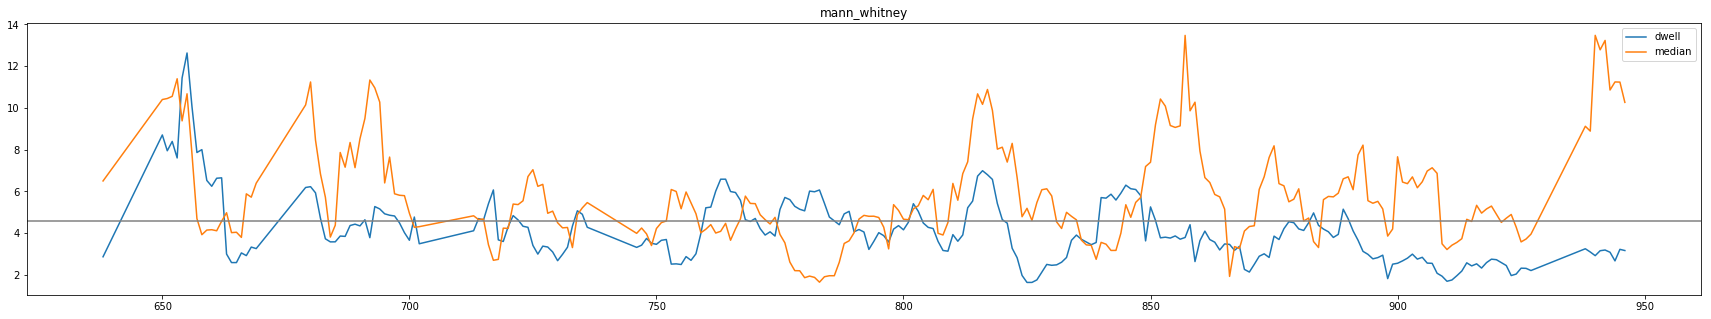

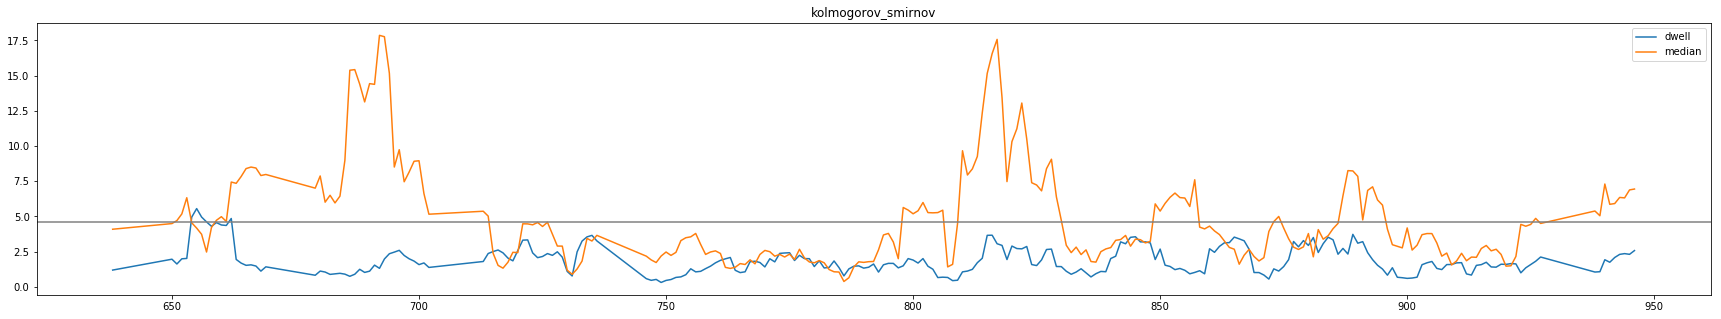

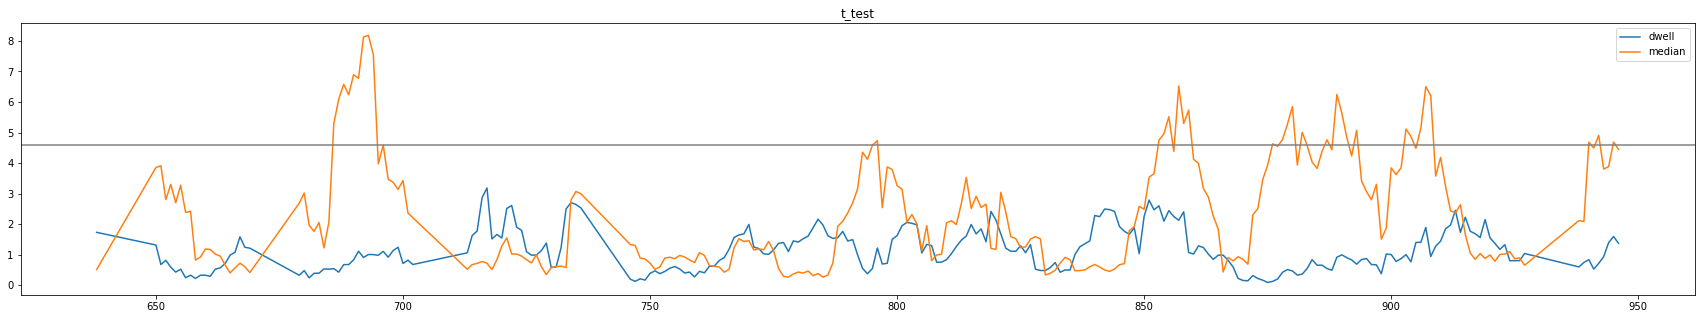

In [19]:
ref_dict = s["YMR116C"]
sig_lim = -np.log (0.01)

for method in ("mann_whitney", "kolmogorov_smirnov", "t_test"):
    stdout_print (method)
    res_dict = paired_test (ref_dict, method=method, sequence_context=4, min_coverage=30)
    fig, ax = pl.subplots (figsize=(30,5))
    df = -np.log (pd.DataFrame (res_dict)).transpose()
    _ = df.plot(ax=ax)
    _ = ax.axhline (sig_lim, c="gray")
    _ = ax.set_title (method)

YMR116C

100%|██████████| 412/412 [00:02<00:00, 137.67it/s]


YBR118W

100%|██████████| 556/556 [00:12<00:00, 45.43it/s]


YPR080W

100%|██████████| 556/556 [00:14<00:00, 38.43it/s]


YLR110C

100%|██████████| 397/397 [00:11<00:00, 35.46it/s]


YGL135W

100%|██████████| 38/38 [00:00<00:00, 170.05it/s]


YLR044C

100%|██████████| 240/240 [00:04<00:00, 58.50it/s]


YJR009C

100%|██████████| 400/400 [00:09<00:00, 43.37it/s]


YGR254W

100%|██████████| 939/939 [00:39<00:00, 23.79it/s]


YGR192C

100%|██████████| 513/513 [00:35<00:00, 14.48it/s]


YKL060C

100%|██████████| 433/433 [00:05<00:00, 79.69it/s]


YPL220W

100%|██████████| 38/38 [00:00<00:00, 167.61it/s]

YDR524C-B


100%|██████████| 193/193 [00:01<00:00, 112.24it/s]


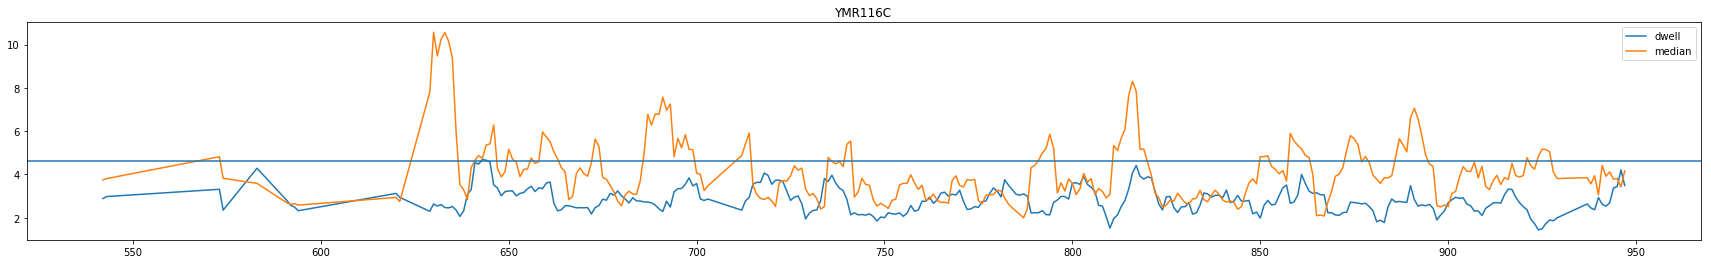

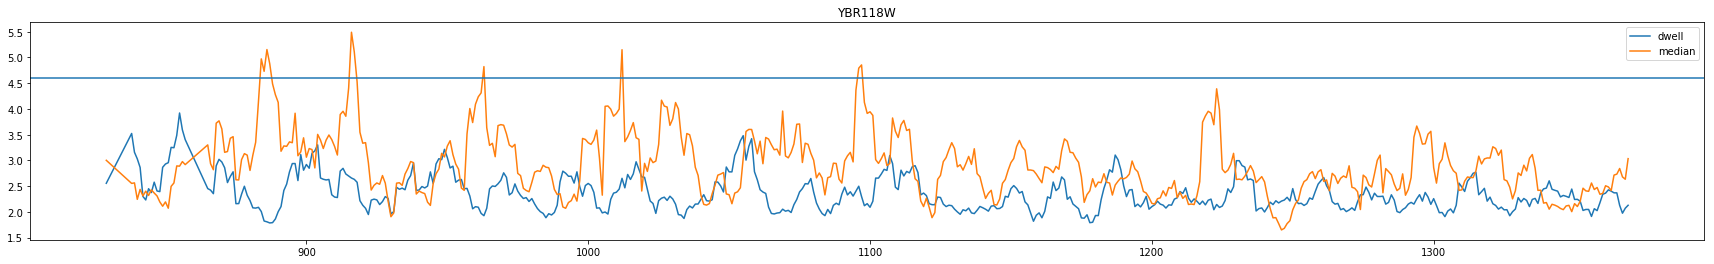

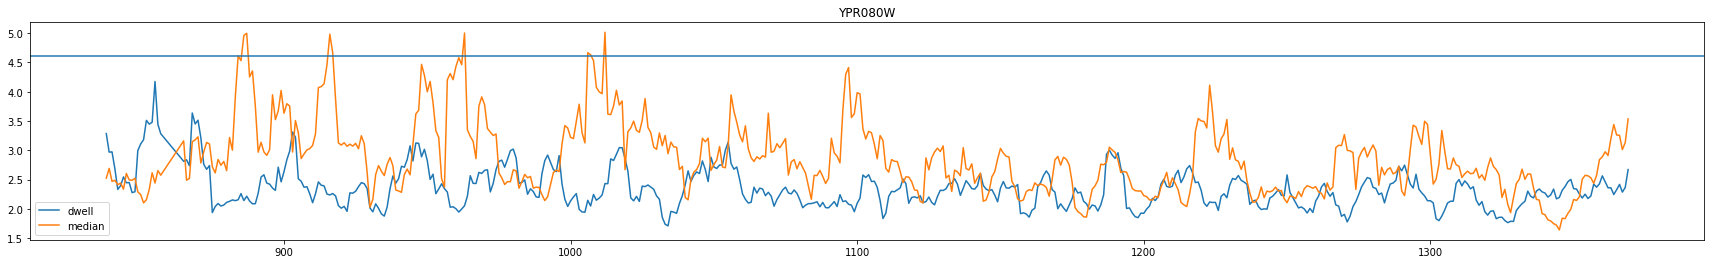

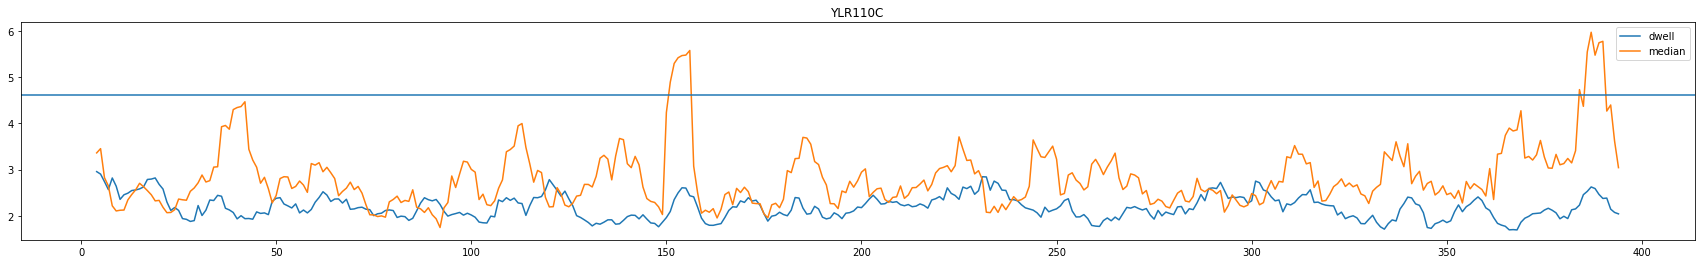

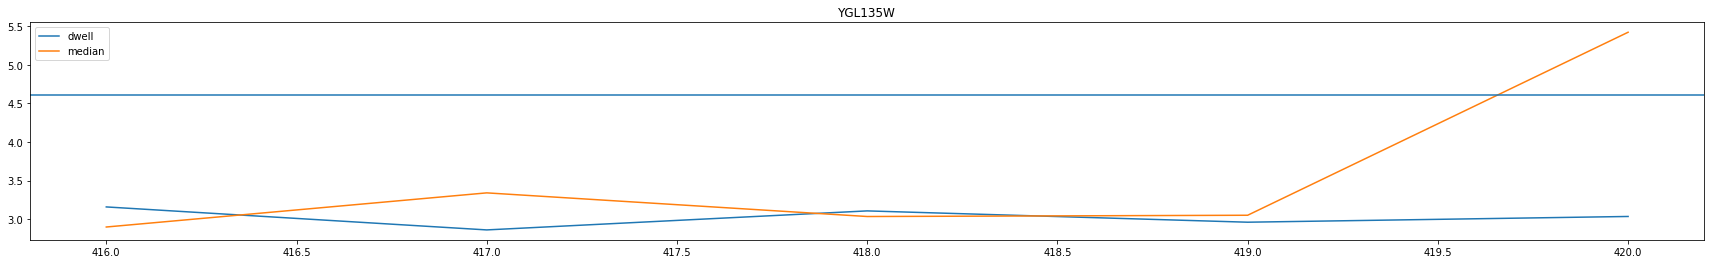

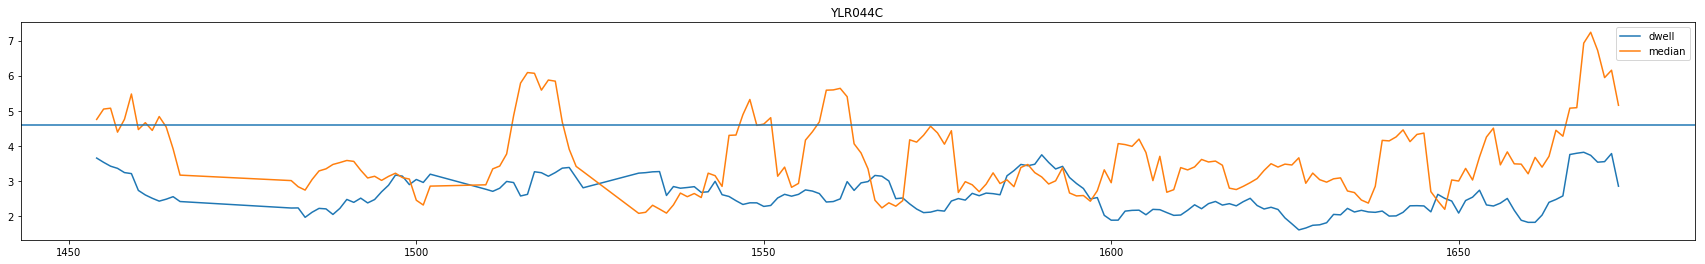

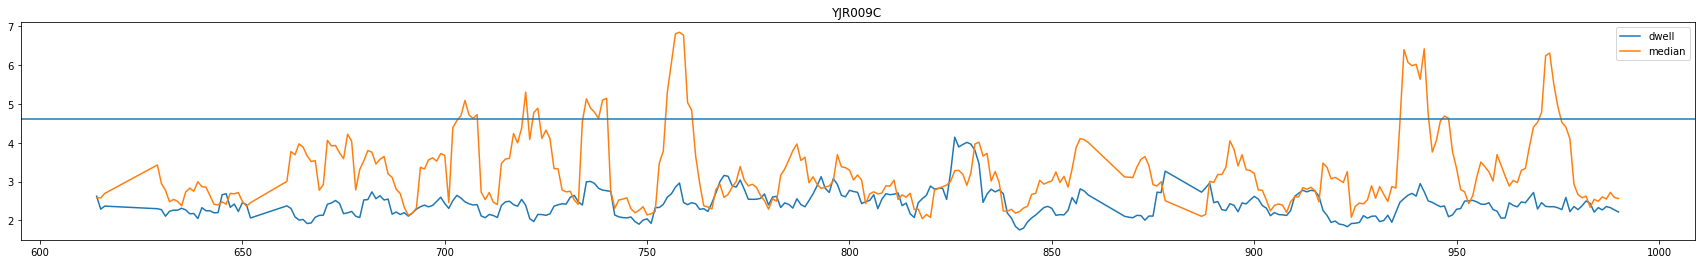

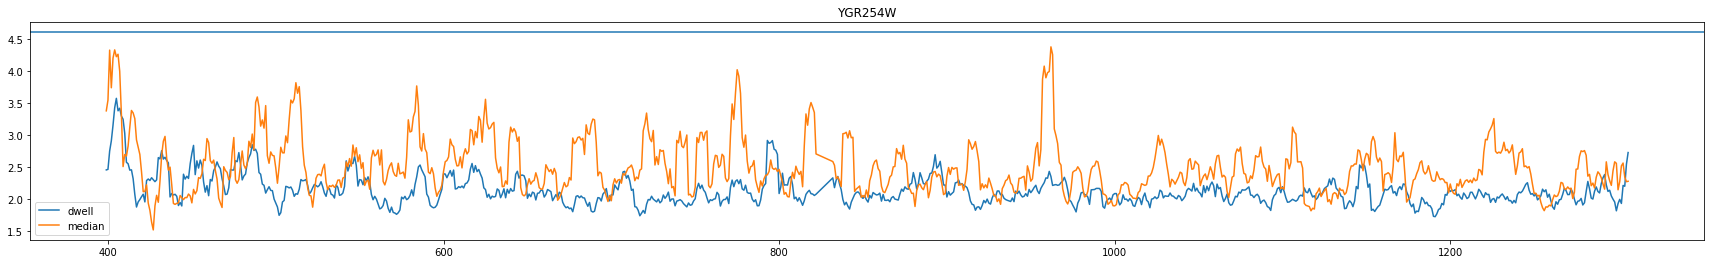

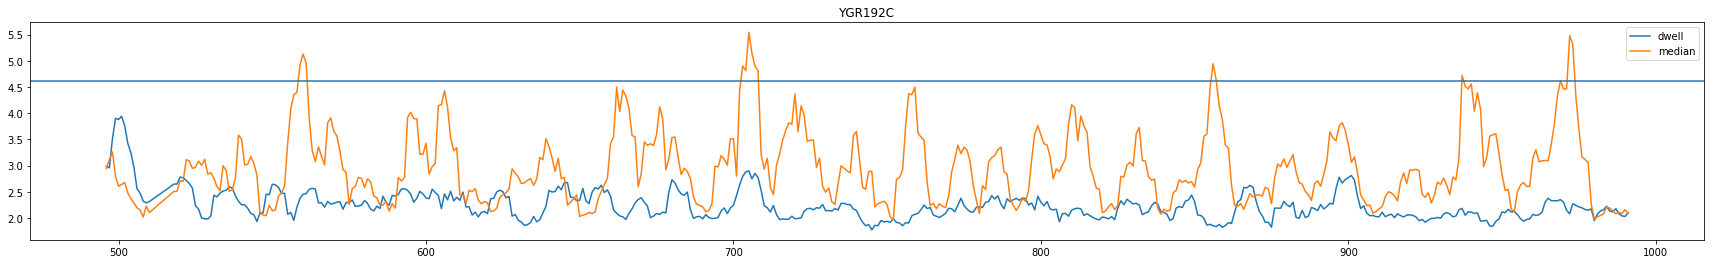

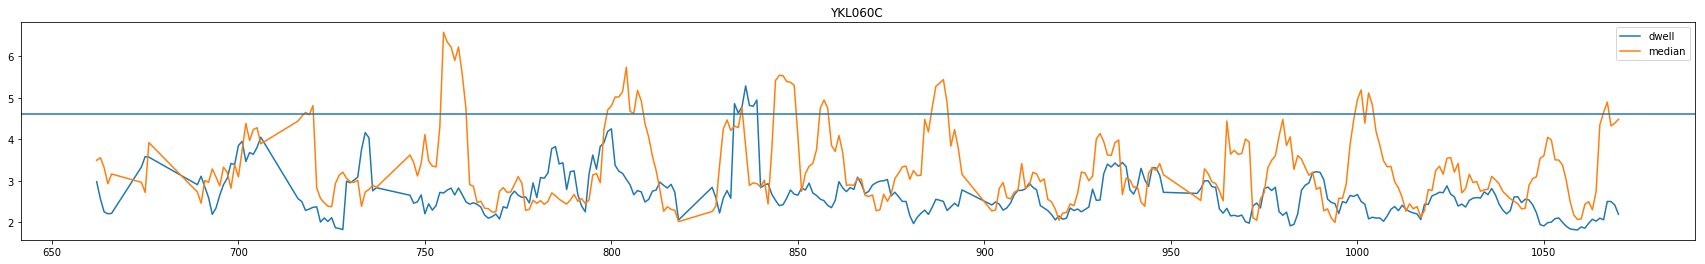

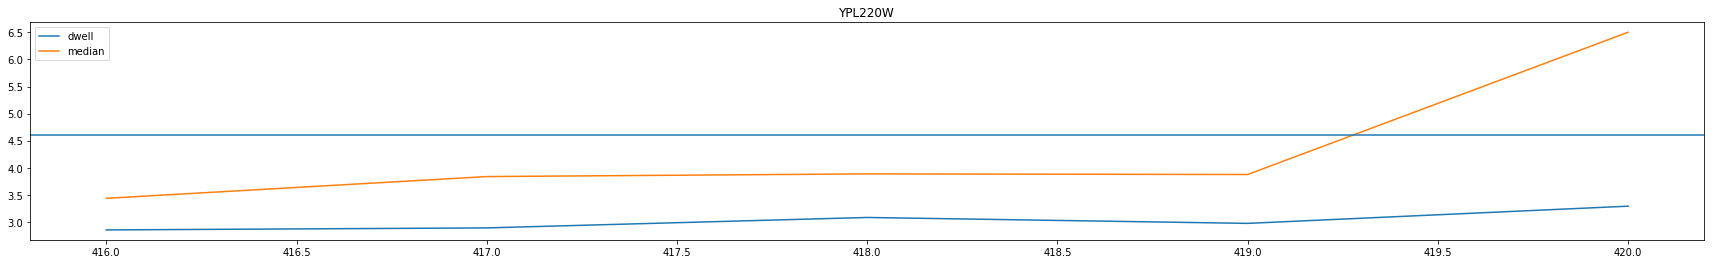

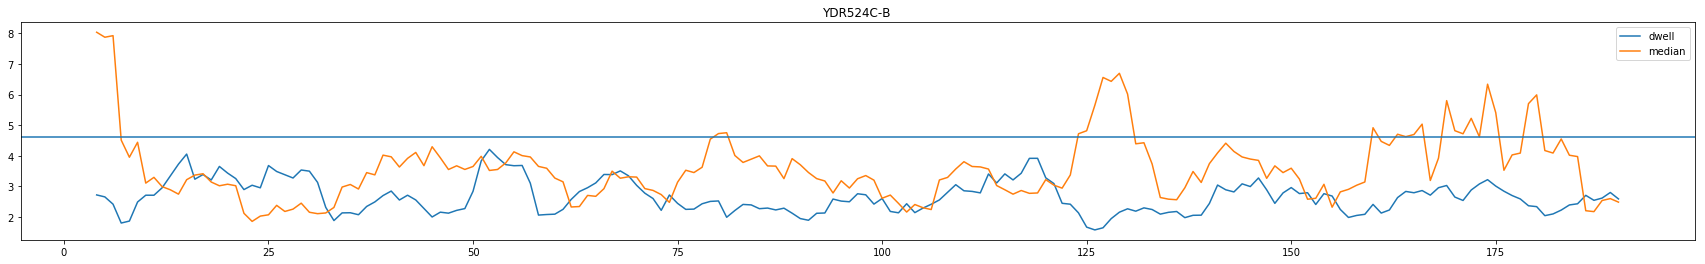

In [16]:
lim = -np.log(0.01)

for ref_id, ref_dict in s:
    if ref_id == "YHR174W":
        continue
    stdout_print (ref_id)
    res_dict = paired_test (ref_dict, method="mann_whitney", sequence_context=3, min_coverage=25)
    
    if res_dict:
        fig, ax = pl.subplots (figsize=(30,4))
        df = -np.log (pd.DataFrame(res_dict)).transpose()
        _ = df.plot (ax=ax)
        _ = ax.axhline (lim)
        _ = ax.set_title (ref_id)

# Test Mixture model

In [22]:
from nanocompore.SampComp import SampComp

s = SampComp (
    max_NNNNN_freq=0.1,
    max_mismatching_freq=0.1,
    max_missing_freq=0.1,
    s1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv",
    s2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv",
    output_db_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db",
    fasta_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa.fai",
    nthreads=8,
    min_coverage=25,
    logLevel = "info")

Initialise and checks options
Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	References found in index: 2126
Filter out references with low coverage
	References remaining after reference coverage filtering: 13
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 13/13 [00:00<00:00, 92.09 References/s]
	References remaining after position coverage filtering: 13
Start data processing
100%|██████████| 13/13 [00:26<00:00,  7.12s/ Processed References]


In [33]:
s["YMR116C"]

OrderedDict([(539,
              {'S1_count': 25,
               'S2_count': 52,
               'S1_median': [110.317,
                110.235,
                108.099,
                108.583496,
                112.261505,
                108.744,
                110.647,
                106.707,
                111.443,
                108.955,
                110.115,
                108.456,
                108.453,
                108.925,
                111.81,
                110.802,
                111.407,
                109.4645,
                108.373,
                107.72,
                111.128,
                110.0905,
                121.145,
                109.672,
                104.746],
               'S2_median': [106.563,
                108.4915,
                109.219,
                102.585,
                108.9505,
                110.037,
                108.0345,
                108.719,
                109.175,
                110.665,
        

In [23]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [24]:
gmm = GaussianMixture (n_components=2, covariance_type="full")
gmm.

/home/aleg/.virtualenvs/Python3.6/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


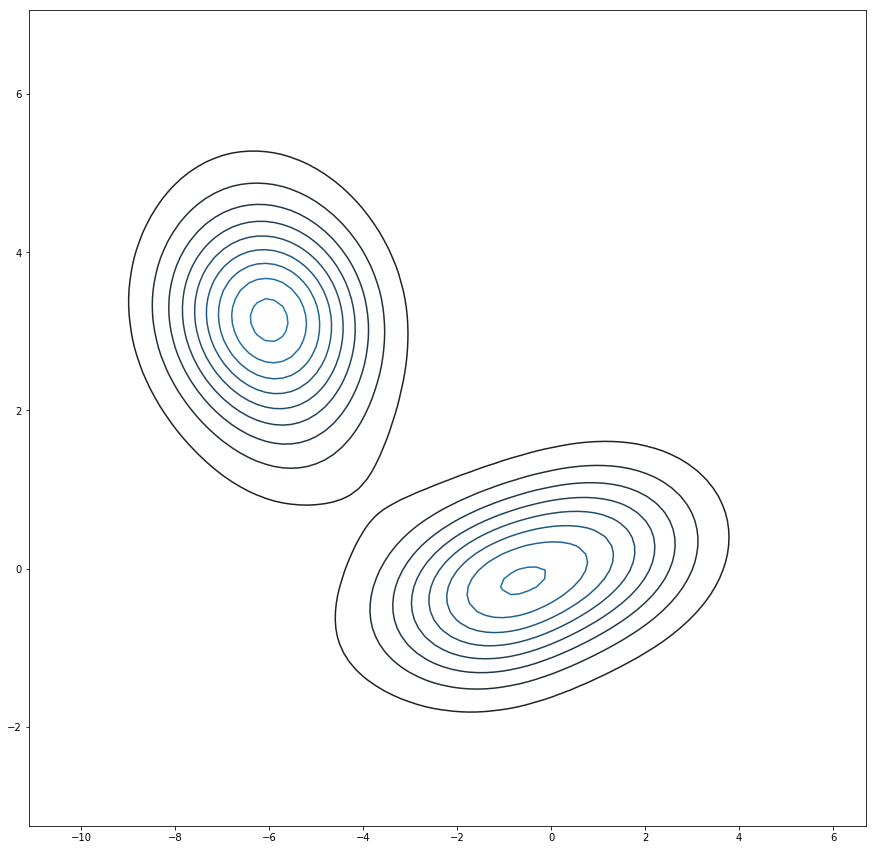

In [35]:



fig, ax = pl.subplots (figsize=(15,15))
sns.kdeplot(X)

# Test Package

In [6]:
from nanocompore.SampComp import SampComp

s = SampComp (
    max_NNNNN_freq=0.1,
    max_mismatching_freq=0.1,
    max_missing_freq=0.1,
    s1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv",
    s2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv",
    output_db_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db",
    fasta_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa.fai",
    nthreads=8,
    min_coverage=20,
    comparison_method = "TT",
    sequence_context = 3,
    downsample_high_coverage = 500,
    logLevel = "debug")

Initialise and checks options
Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 18,501	S1_reads: 7,425	S2_reads: 4,745	ref_id: 19
	References remaining after reference coverage filtering: 19
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 19/19 [00:00<00:00, 153.75 References/s]
	positions: 7,456	S2_reads: 2,257	S1_reads: 1,656	intervals: 14	ref_id: 14
	References remaining after position coverage filtering: 14
Start data processing
100%|██████████| 14/14 [00:37<00:00,  2.43s/ Processed References]


In [8]:
s.ref_id_list

['YMR116C',
 'YOR369C',
 'YBR118W',
 'YPR080W',
 'YLR110C',
 'YGL135W',
 'YLR044C',
 'YJR009C',
 'YGR254W',
 'YGR192C',
 'YHR174W',
 'YKL060C',
 'YPL220W',
 'YDR524C-B']

In [10]:
df =  pd.DataFrame.from_dict(s["YMR116C"], orient="index")
df.sort_values(by="pvalue_median")

S1_median  \
579  [116.179, 104.054, 114.395, 118.286, 109.488, 118.65, 110.733, 112.247, 109.606, 105.386, 108.387, 115.18, 121.22, 106.307, 118.779, 103.1285, 114.511, 105.673, 111.7875, 121.001, 111.146, 114.438...   
690  [91.35245, 89.7479, 86.1695, 92.63695, 93.5197, 98.921, 86.2028, 91.869354, 94.046005, 88.1151, 88.0453, 94.9782, 91.1036, 90.6103, 95.8273, 91.129, 87.5587, 90.267, 93.3071, 88.1894, 86.634155, 9...   
814  [91.8314, 87.3469, 90.5816, 86.4544, 97.879196, 90.4224, 90.7509, 90.6105, 91.298904, 89.765, 88.7254, 89.7581, 90.3286, 93.1387, 93.0447, 89.0041, 88.9737, 90.5354, 91.4287, 88.48205, 89.628, 83....   
538  [88.66295, 91.9703, 87.56775, 90.01465, 89.2061, 88.1307, 87.29405, 88.6632, 91.9262, 86.2337, 92.2013, 87.405304, 88.6251, 88.7788, 89.70325, 90.3922, 92.400696, 91.247, 87.1775, 86.2392, 88.3292...   
738  [88.387146, 88.84505, 86.3167, 89.1642, 86.4544, 89.6934, 88.5308, 87.172, 90.1719, 84.786545, 90.69655, 89.5591, 85.93415, 91.7374, 90.3007, 88.9185, 87.1251, 87.6804, 88.318, 90.0077, 88.3307, 8...   
818  [90.5813, 93.5285, 90.0146, 87.7931, 94.3072, 89.8403, 89.707, 91.3414, 91.73305, 91.6281, 91.5044, 91.0328, 91.7374, 94.483, 92.3079, 94.0629, 92.206955, 92.1984, 92.0188, 91.222, 93.6072, 89.280...   
632  [107.283, 106.277, 106.922, 105.89, 108.0965, 103.535, 106.937, 111.628, 106.692, 106.856, 107.822, 107.8315, 103.6375, 107.0235, 107.926, 104.686, 103.205, 104.9485, 107.8415, 105.001, 110.998, 1...   
692  [81.5599, 77.59445, 74.3951, 78.675, 76.26535, 79.2752, 77.7636, 75.8448, 77.5507, 78.8016, 80.1104, 79.2777, 78.9171, 79.32215, 78.1611, 78.74194, 77.0467, 76.81525, 78.8179, 72.8405, 77.8828, 77...   
904  [89.95625, 93.08695, 90.7234, 91.2142, 91.3306, 89.913055, 92.2917, 89.707, 86.25385, 91.57385, 89.6165, 91.4556, 91.645, 91.8658, 90.3049, 89.1174, 81.943, 90.76485, 90.4289, 89.4806, 86.1187, 90...   
743  [114.3165, 112.18, 111.337, 110.7805, 112.038, 120.4275, 109.8385, 113.563, 111.6315, 115.776505, 107.484, 110.577, 112.165, 118.979, 131.801, 114.009, 110.908, 108.2465, 113.358, 111.8825, 100.69...   
792  [102.457, 101.329, 101.496, 102.221, 104.874, 101.335, 102.745, 100.995, 102.09, 101.926, 101.0885, 102.304, 103.744, 104.834, 104.18, 101.188, 103.147, 103.296, 103.231, 103.696, 103.04, 98.6286,...   
545  [85.4218, 84.7476, 85.4336, 83.9196, 85.1156, 83.591354, 83.8747, 84.3387, 85.3475, 84.7866, 85.0357, 84.14, 84.5179, 85.2568, 86.93995, 86.5607, 85.5352, 85.7606, 83.8006, 84.1604, 83.5736, 85.67...   
633  [74.5258, 74.1915, 74.2479, 78.2497, 74.92665, 73.6196, 74.126, 74.19835, 75.991, 72.3408, 74.5739, 77.3313, 72.69205, 73.4931, 74.01965, 74.9192, 72.5369, 74.3207, 75.8806, 72.5454, 73.4161, 76.6...   
944  [82.17805, 82.4164, 83.9196, 83.4795, 81.9832, 83.4469, 80.5897, 81.6388, 79.41935, 82.58, 82.309555, 83.6872, 81.57326, 83.9049, 81.9641, 80.2074, 81.04905, 85.1331, 80.475, 82.4642, 83.459946, 7...   
861  [77.9417, 76.82355, 80.6594, 77.82715, 80.6147, 77.1816, 77.40445, 79.6459, 79.432, 76.7236, 78.65135, 77.2949, 77.79, 80.5918, 78.0138, 79.97055, 80.7829, 75.9837, 77.4138, 75.4313, 76.5111, 86.8...   
889  [83.0809, 81.1654, 82.5021, 82.5126, 86.2703, 82.2742, 84.56235, 83.5931, 83.4841, 86.6121, 84.9737, 81.11885, 83.918396, 85.3716, 85.2345, 85.8243, 83.2258, 84.4375, 88.6257, 85.0932, 90.807, 79....   
456       [102.386, 102.873505, 100.74, 102.914, 103.932, 106.437, 103.5175, 101.488, 108.15401, 99.6926, 118.284, 104.566, 102.4335, 102.304, 105.984, 104.686, 101.579, 106.44, 103.559, 103.632, 103.629]   
561  [90.2491, 91.1369, 94.632355, 90.2981, 89.1318, 91.107346, 91.5864, 89.33425, 89.1485, 92.4566, 91.9147, 90.1149, 90.89114, 89.765, 95.2299, 91.20265, 90.883, 93.3571, 89.76405, 94.9701, 91.1966, ...   
496  [104.524, 102.943, 101.329, 104.331, 100.585, 101.749, 105.772995, 101.3385, 103.768, 98.31775, 104.383, 97.54875, 100.8755, 103.501, 104.939, 101.518, 105.1195, 102.29, 103.3435, 84.4375, 105.324...   
546  [94.5247, 94.7482, 95.1475, 94

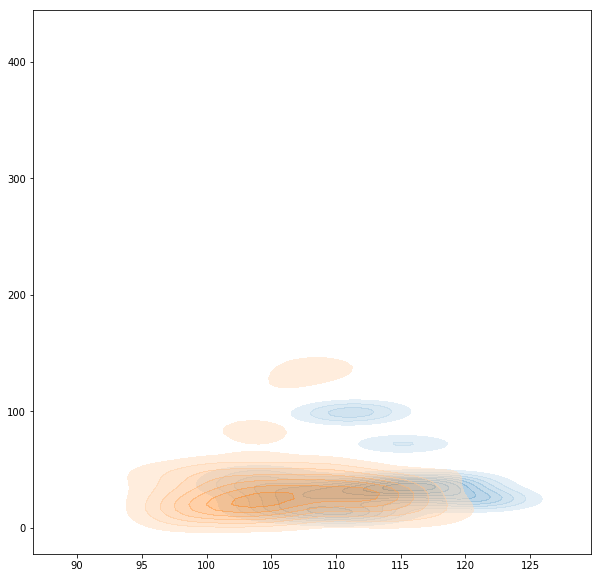

In [26]:
r = df.loc[579]
# fig, ax = pl.subplots (figsize=(10,10))
# ax.scatter (r["S1_median"], r["S1_dwell"])
# ax.scatter (r["S2_median"], r["S2_dwell"])

fig, ax = pl.subplots (figsize=(10,10))
sns.kdeplot (r["S1_median"], r["S1_dwell"], ax=ax, shade=True, alpha=0.5, shade_lowest=False)
sns.kdeplot (r["S2_median"], r["S2_dwell"], ax=ax, shade=True, alpha=0.5, shade_lowest=False)

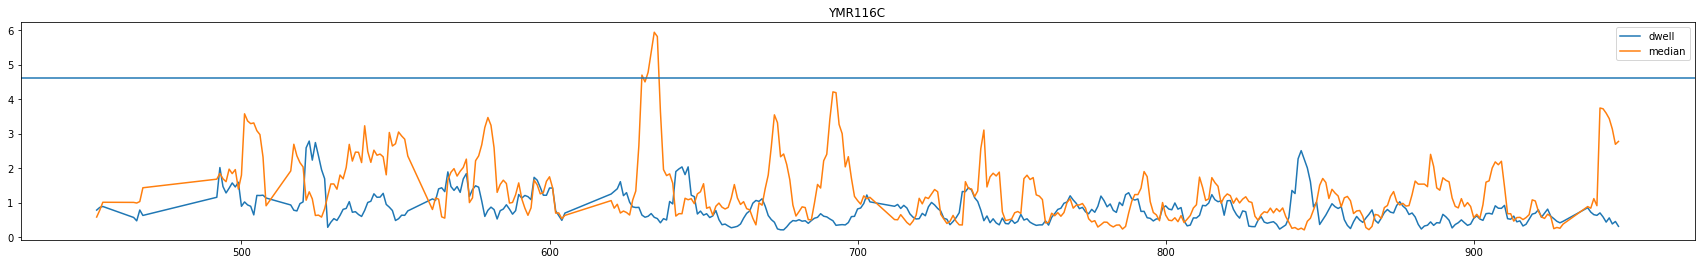

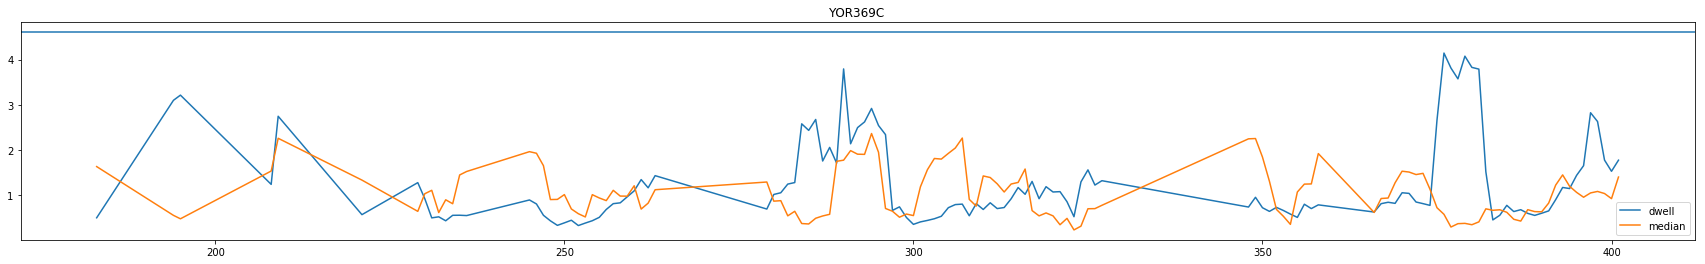

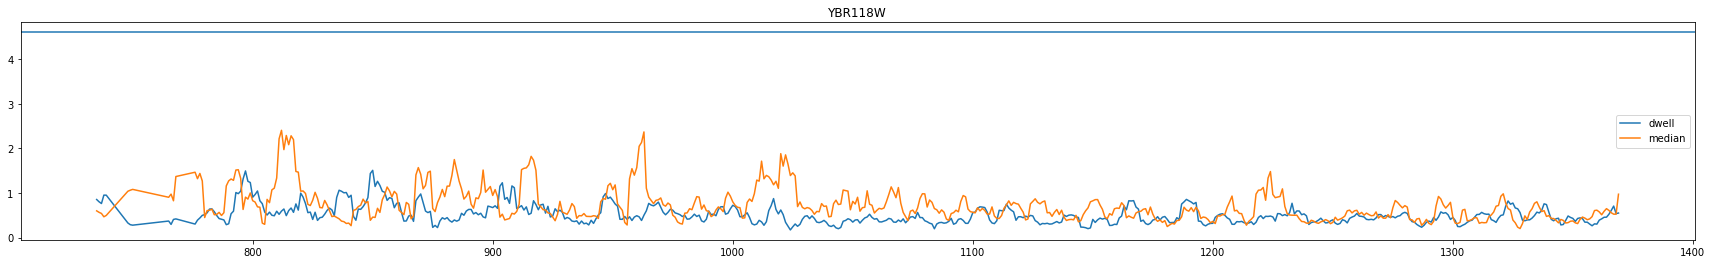

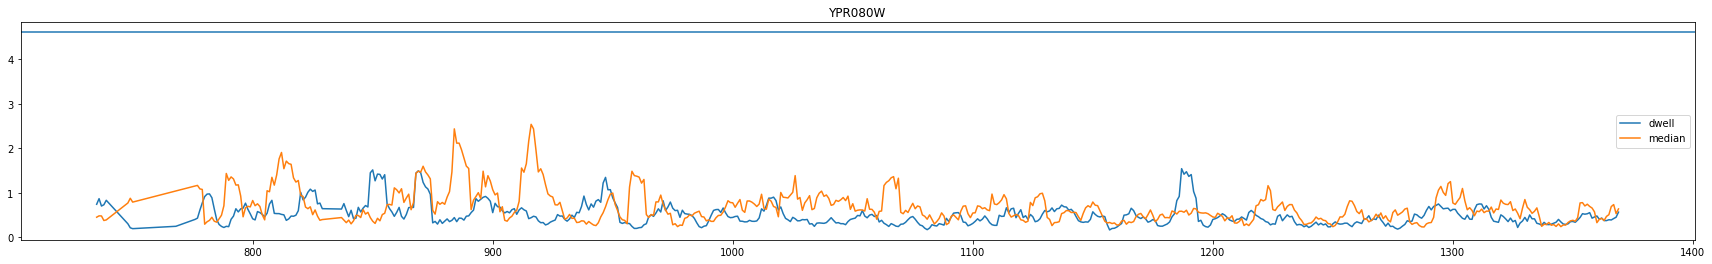

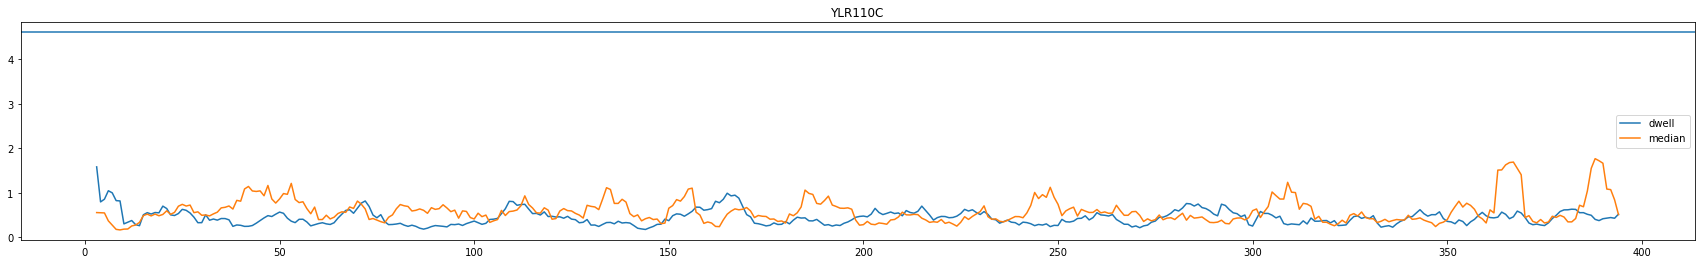

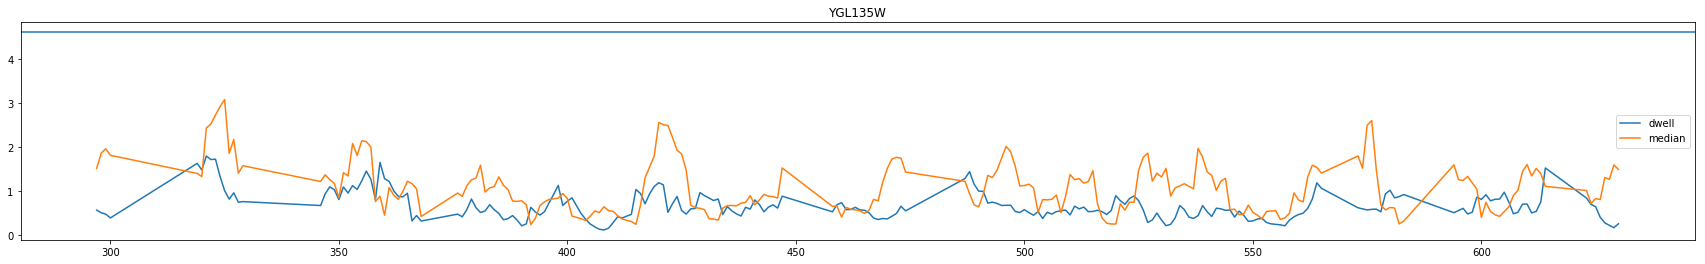

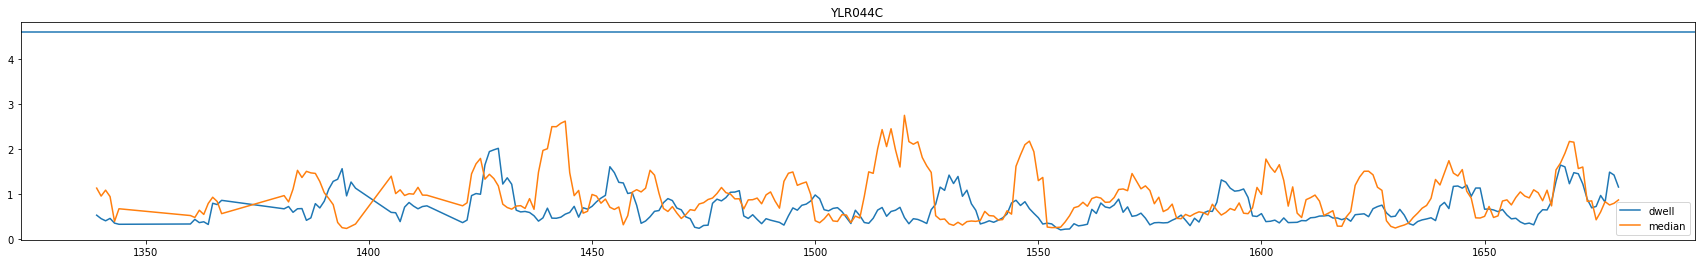

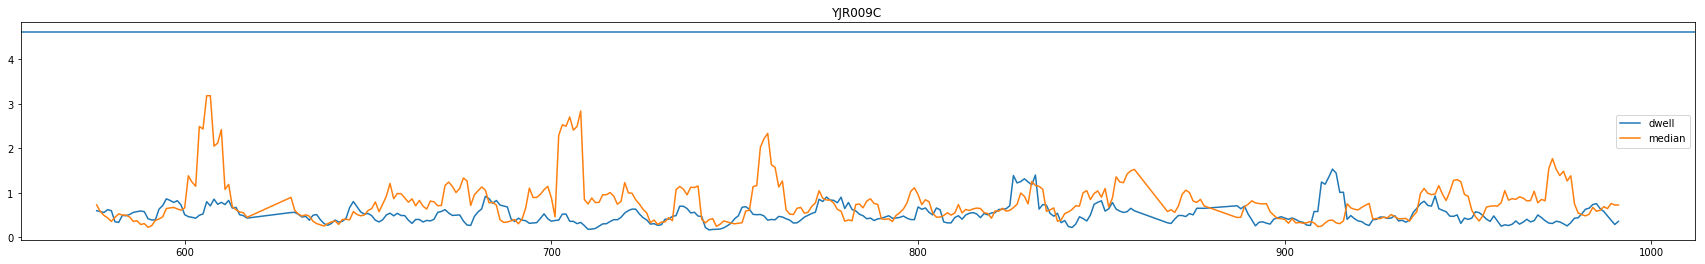

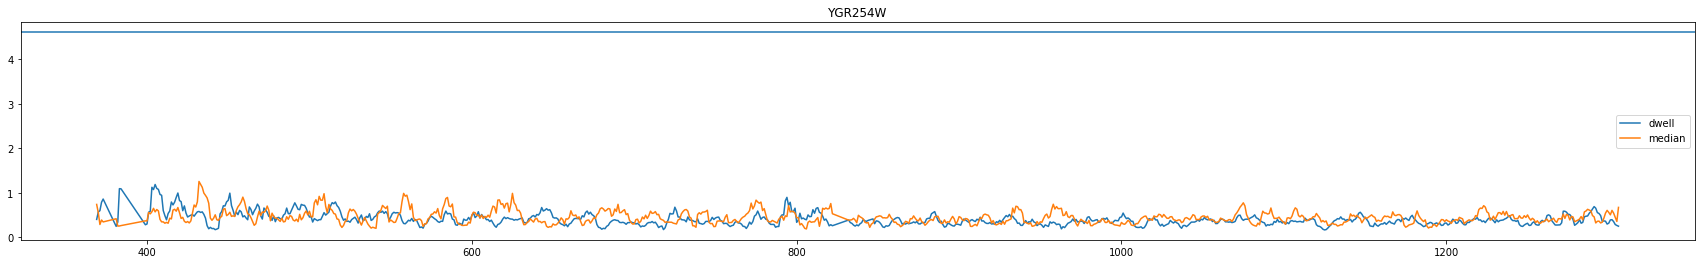

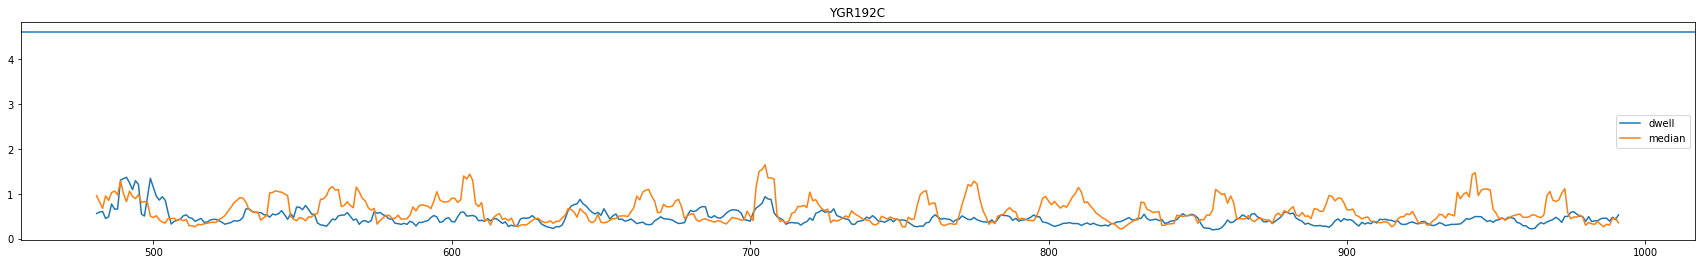

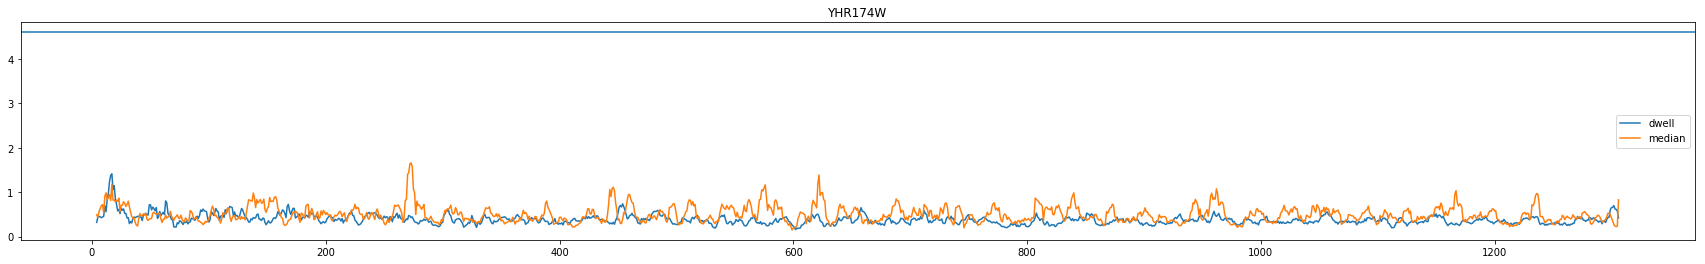

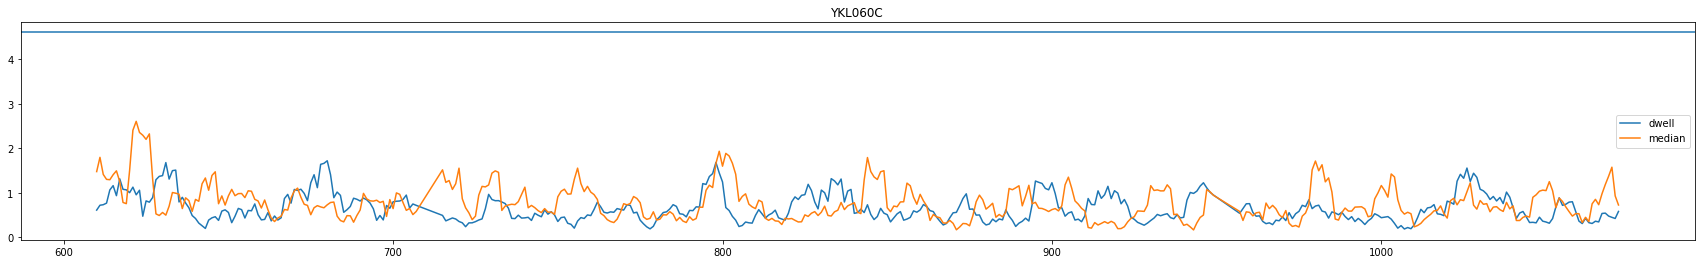

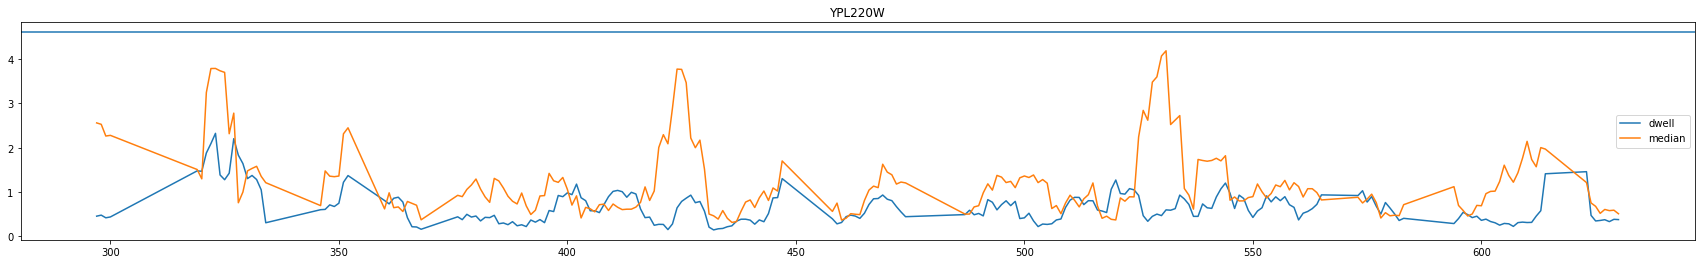

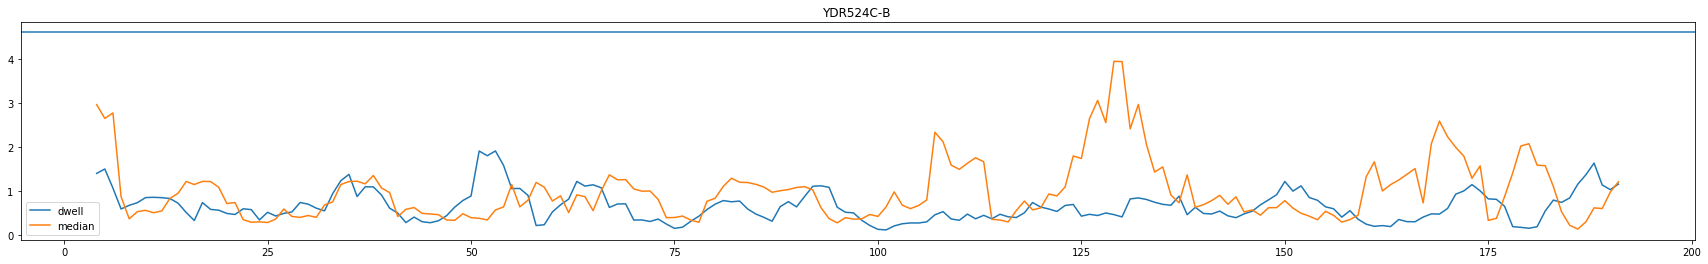

In [7]:
lim = -np.log(0.01)

for ref_id, res_dict in s:
    fig, ax = pl.subplots (figsize=(30,4))
    df = -np.log (pd.DataFrame(res_dict)).transpose()
    _ = df.plot (ax=ax)
    _ = ax.axhline (lim)
    _ = ax.set_title (ref_id)